In [16]:
import pandas as pd

In [17]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
498581


In [18]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [19]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series_seq = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_block_numeric,offense_date,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,2018-01-07,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62
1,0,2018-01-14,3.931818,13.840909,1.000000,10.727273,39.481495,25.380132,33891.959251,0.225304,8.454545,1.000000,44
2,0,2018-01-21,3.800000,14.171429,1.000000,18.028571,33.977197,18.672054,34573.083036,0.036670,4.057143,0.800000,35
3,0,2018-01-28,4.017857,12.696429,1.000000,24.625000,46.487669,32.168027,35307.395717,0.092238,7.750000,1.178571,56
4,0,2018-02-04,4.780488,11.317073,1.658537,11.878049,33.318698,17.041868,36302.567645,0.059823,7.024390,1.268293,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45705,242,2023-12-31,4.000000,7.000000,12.000000,27.000000,51.206001,44.456001,33089.515625,0.370079,17.000000,2.000000,1
45706,242,2024-01-07,2.000000,0.000000,1.000000,1.000000,35.186001,30.776001,33260.843750,0.114173,15.000000,3.000000,1
45707,242,2024-03-03,1.000000,3.000000,3.000000,3.000000,60.116001,37.166000,40985.230469,0.000000,0.000000,3.000000,3
45708,242,2024-05-19,2.000000,6.000000,5.000000,13.000000,77.216003,53.096001,52093.277344,0.000000,0.000000,2.000000,1


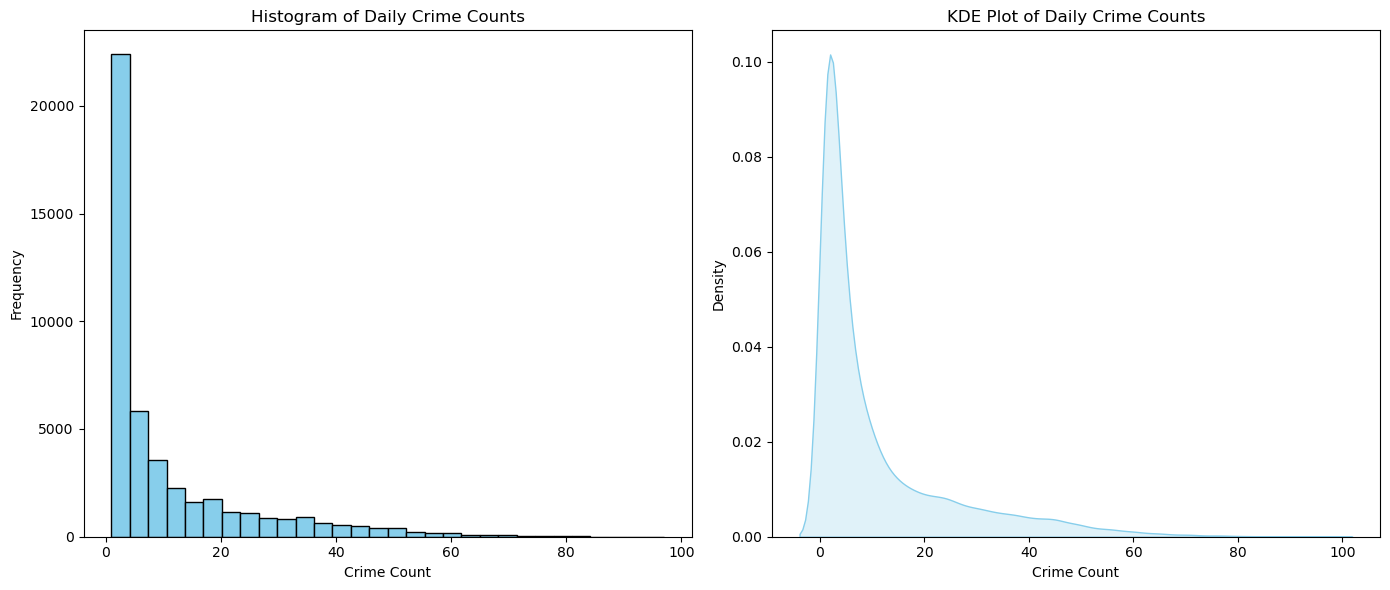

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Crime_Count' is the column with daily crime counts
crime_counts = crime_time_series['Crime_Count_W']

# Set up the figure for multiple visualizations
plt.figure(figsize=(14, 6))

# Histogram to show the distribution of daily crime counts
plt.subplot(1, 2, 1)
plt.hist(crime_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Crime Count')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Crime Counts')

# KDE (Kernel Density Estimate) plot for a smooth frequency distribution
plt.subplot(1, 2, 2)
sns.kdeplot(crime_counts, fill=True, color='skyblue')
plt.xlabel('Crime Count')
plt.ylabel('Density')
plt.title('KDE Plot of Daily Crime Counts')

# Show both visualizations
plt.tight_layout()
plt.show()

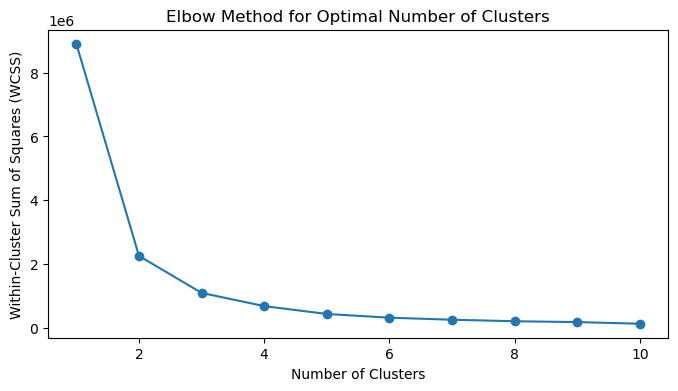

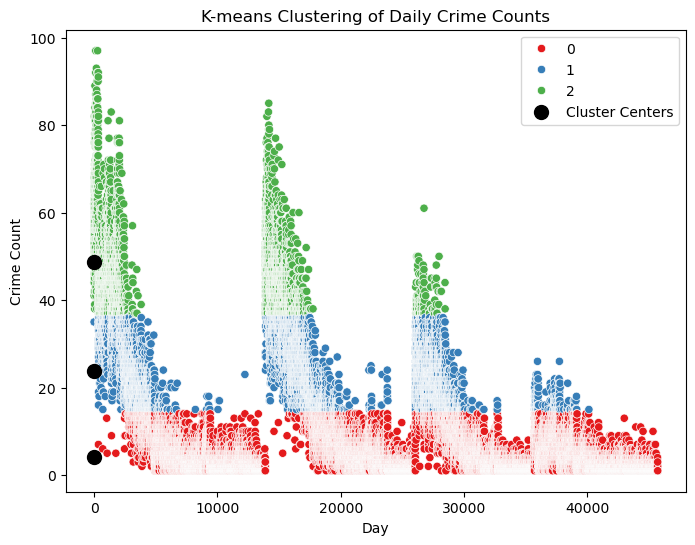

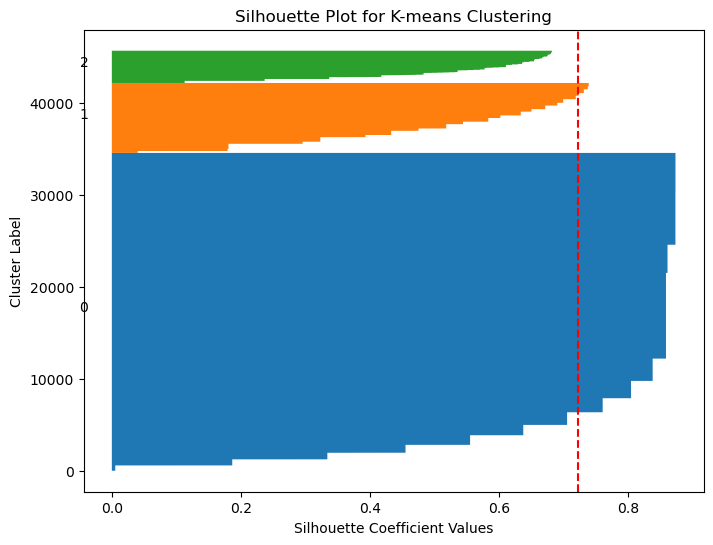

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Crime_Count' is the column with daily crime counts
crime_counts = crime_time_series['Crime_Count_W'].values.reshape(-1, 1)

# Determine optimal clusters for K-means using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(crime_counts)
    wcss.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Apply K-means clustering with an optimal number of clusters (let’s assume 3 for this example)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
crime_counts_kmeans_labels = kmeans.fit_predict(crime_counts)

# Add the cluster labels as bins in the DataFrame
crime_time_series['Crime_KMeans_Bin'] = crime_counts_kmeans_labels

# Visualize K-means cluster centers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(crime_counts)), y=crime_counts.flatten(), hue=crime_counts_kmeans_labels, palette='Set1')
plt.scatter(range(len(kmeans.cluster_centers_)), kmeans.cluster_centers_, color='black', label='Cluster Centers', s=100)
plt.title('K-means Clustering of Daily Crime Counts')
plt.xlabel('Day')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Silhouette plot
plt.figure(figsize=(8, 6))
silhouette_vals = silhouette_samples(crime_counts, crime_counts_kmeans_labels)
silhouette_avg = silhouette_score(crime_counts, crime_counts_kmeans_labels)
y_lower, y_upper = 0, 0

for i in range(optimal_clusters):
    ith_cluster_silhouette_vals = silhouette_vals[crime_counts_kmeans_labels == i]
    ith_cluster_silhouette_vals.sort()
    y_upper += len(ith_cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals)
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_vals), str(i))
    y_lower = y_upper

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for K-means Clustering")
plt.show()

In [20]:
crime_time_series.columns

Index(['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month',
       'extracted_day', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'time_block_numeric',
       'Crime_Count_W', 'Crime_KMeans_Bin'],
      dtype='object')

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = [] 
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [12]:
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.7248035392921413
  Root Mean Squared Error (RMSE): 4.5061835389809195
  R² Score: 0.8900716186061632



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.6929124175164967
  Root Mean Squared Error (RMSE): 4.512534163536557
  R² Score: 0.894462123943491



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.6667646617669116
  Root Mean Squared Error (RMSE): 4.429530798272585
  R² Score: 0.8958417326780777



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.7127463626818655
  Root Mean Squared Error (RMSE): 4.432888437013191
  R² Score: 0.8957087423697819



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.7167721613919307
  Root Mean Squared Error (RMSE): 4.509961994533922
  R² Score: 0.8966550535517848

Average MAE across 5 folds: 2.7027998285298693
Average RMSE across 5 folds: 4.4782197864674345
Average R² Score across 5 folds: 0.8945478542298598


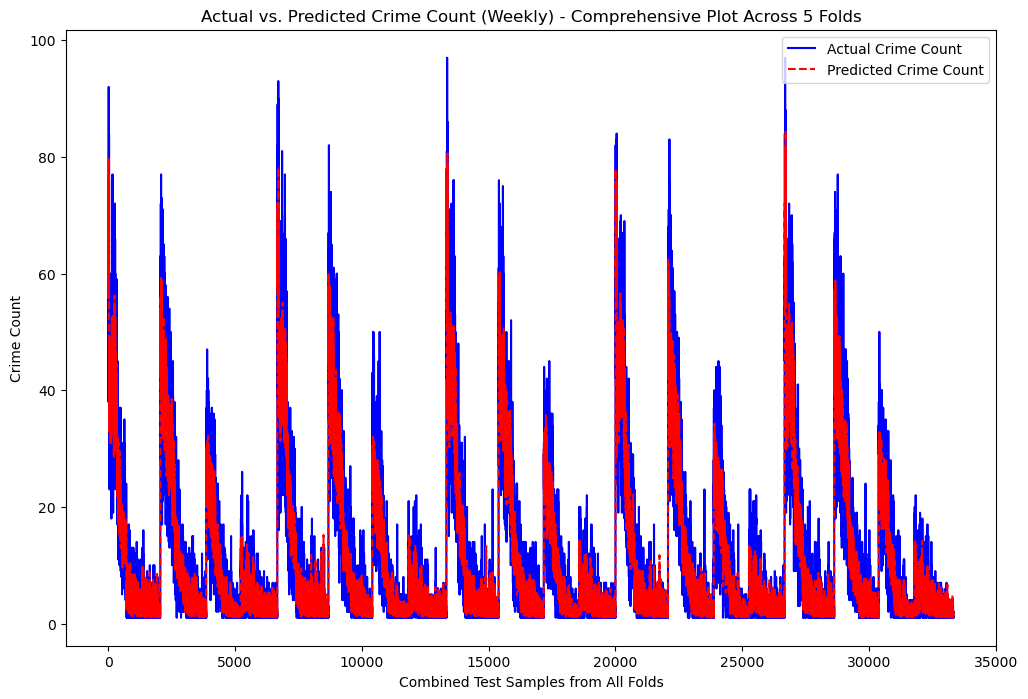

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.598749684936839
  Root Mean Squared Error (RMSE): 4.351071080055895
  R² Score: 0.9069569110870361



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.5576758808630564
  Root Mean Squared Error (RMSE): 4.350389937009347
  R² Score: 0.9055888652801514



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.5200518960415588
  Root Mean Squared Error (RMSE): 4.227732527694873
  R² Score: 0.9056406617164612



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.547075462283944
  Root Mean Squared Error (RMSE): 4.319438811179637
  R² Score: 0.8998797535896301



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.592233641809598
  Root Mean Squared Error (RMSE): 4.328667154502544
  R² Score: 0.9038032293319702

Average MAE across 5 folds: 2.5631573131869994
Average RMSE across 5 folds: 4.315459902088459
Average R² Score across 5 folds: 0.9043738842010498


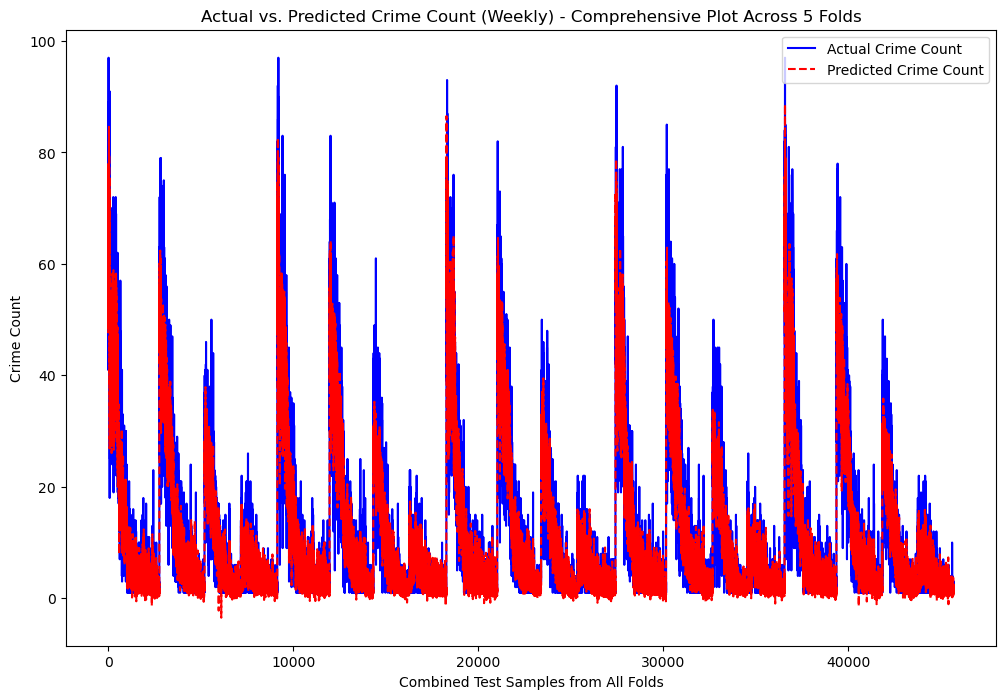

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

# Perform grid search
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1)
grid_search.fit(X, y)

# Retrieve the best model with optimized hyperparameters
best_model = grid_search.best_estimator_

# Use the best_model directly in k-fold cross-validation
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(best_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.5958013282435144
  Root Mean Squared Error (RMSE): 4.359450401159542
  R² Score: 0.8971141576766968



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.5941304820315967
  Root Mean Squared Error (RMSE): 4.431130924064588
  R² Score: 0.8982354402542114



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.576657363327447
  Root Mean Squared Error (RMSE): 4.319309935608491
  R² Score: 0.9009608030319214



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.5824349859510933
  Root Mean Squared Error (RMSE): 4.233474705200084
  R² Score: 0.9048807621002197



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.6213048980496594
  Root Mean Squared Error (RMSE): 4.440972214493981
  R² Score: 0.8997926712036133

Average MAE across 5 folds: 2.594065811520662
Average RMSE across 5 folds: 4.356867636105338
Average R² Score across 5 folds: 0.9001967668533325


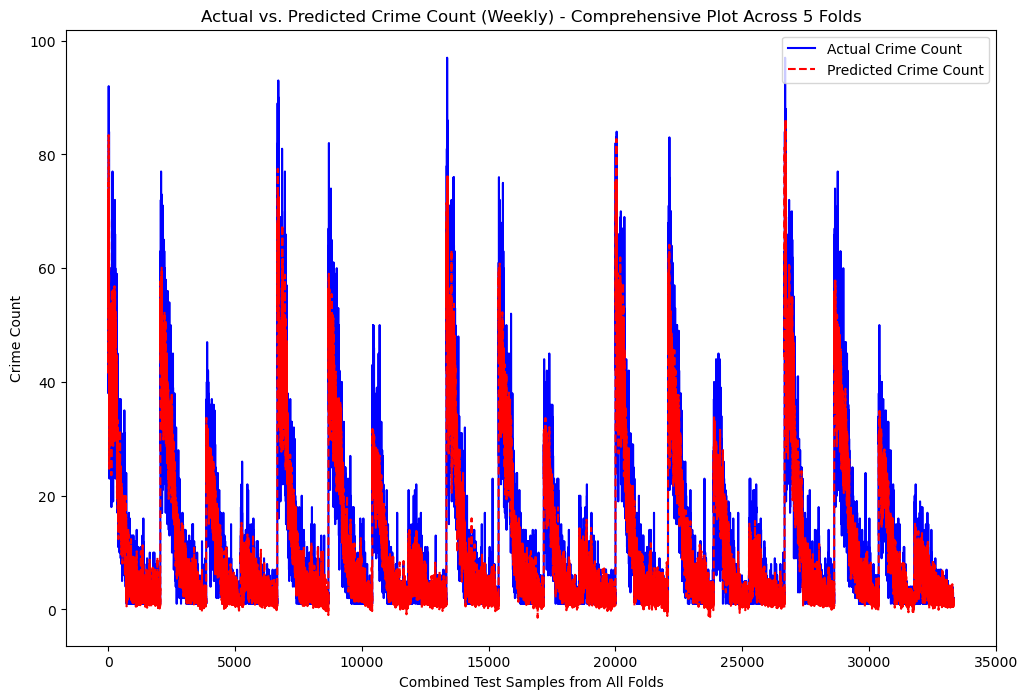

In [104]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

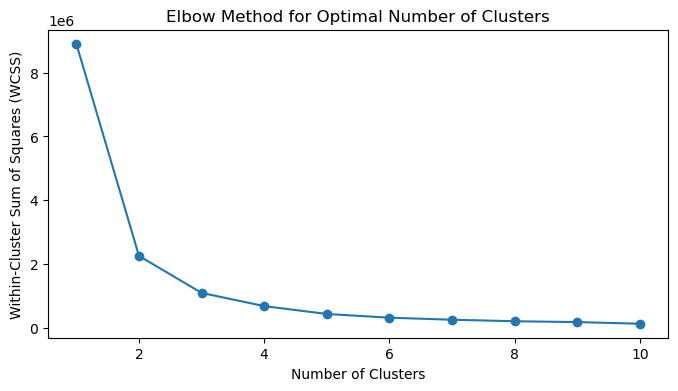

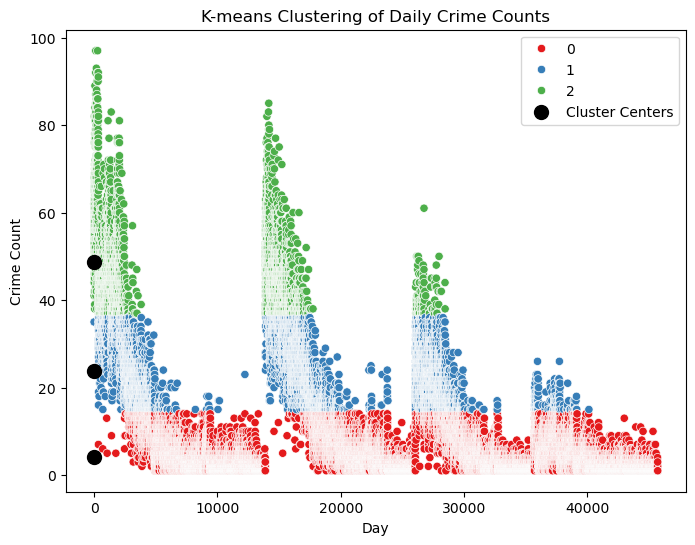

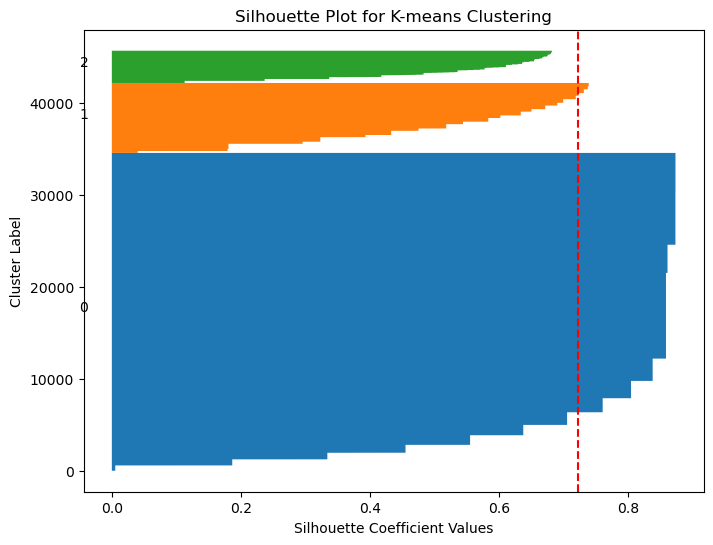

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Crime_Count' is the column with daily crime counts
crime_counts = crime_time_series['Crime_Count_W'].values.reshape(-1, 1)

# Determine optimal clusters for K-means using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(crime_counts)
    wcss.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Apply K-means clustering with an optimal number of clusters (let’s assume 3 for this example)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
crime_counts_kmeans_labels = kmeans.fit_predict(crime_counts)

# Add the cluster labels as bins in the DataFrame
crime_time_series['Crime_KMeans_Bin'] = crime_counts_kmeans_labels

# Visualize K-means cluster centers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(crime_counts)), y=crime_counts.flatten(), hue=crime_counts_kmeans_labels, palette='Set1')
plt.scatter(range(len(kmeans.cluster_centers_)), kmeans.cluster_centers_, color='black', label='Cluster Centers', s=100)
plt.title('K-means Clustering of Daily Crime Counts')
plt.xlabel('Day')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Silhouette plot
plt.figure(figsize=(8, 6))
silhouette_vals = silhouette_samples(crime_counts, crime_counts_kmeans_labels)
silhouette_avg = silhouette_score(crime_counts, crime_counts_kmeans_labels)
y_lower, y_upper = 0, 0

for i in range(optimal_clusters):
    ith_cluster_silhouette_vals = silhouette_vals[crime_counts_kmeans_labels == i]
    ith_cluster_silhouette_vals.sort()
    y_upper += len(ith_cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals)
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_vals), str(i))
    y_lower = y_upper

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for K-means Clustering")
plt.show()

In [22]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_KMeans_Bin'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_KMeans_Bin')['Crime_Count_W'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_KMeans_Bin
0    34587
1     7612
2     3511
Name: count, dtype: int64
Bucket Summary Statistics:
                     count       mean        std   min   25%   50%   75%   max
Crime_KMeans_Bin                                                             
0                 34587.0   4.229971   3.485714   1.0   1.0   3.0   6.0  14.0
1                  7612.0  23.822254   6.203407  15.0  18.0  23.0  29.0  36.0
2                  3511.0  48.688123  10.310058  37.0  41.0  46.0  54.0  97.0


In [29]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day']
"""
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours']
"""

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_KMeans_Bin'].values
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 17

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (2688, 17, 4)
X_spatial: (2688, 1)
y: (2688,)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Fold AUC (OvR): 0.9670, Accuracy: 0.8606, F1 Score: 0.7239
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Fold AUC (OvR): 0.9666, Accuracy: 0.8680, F1 Score: 0.7610
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Fold AUC (OvR): 0.9540, Accuracy: 0.7900, F1 Score: 0.6611
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Fold AUC (OvR): 0.9720, Accuracy: 0.8454, F1 Score: 0.7161
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Fold AUC (OvR): 0.9687, Accuracy: 0.8399, F1 Score: 0.7223

Average AUC: 0.9657 ± 0.0061
Average Accuracy: 0.8408 ± 0.0274
Average F1 Score: 0.7169 ± 0.0321
AUC for class 0: 0.9791
AUC for class 1: 0.8960
AUC for class 2: 0.9697
Mean AUC across classes: 0.9482


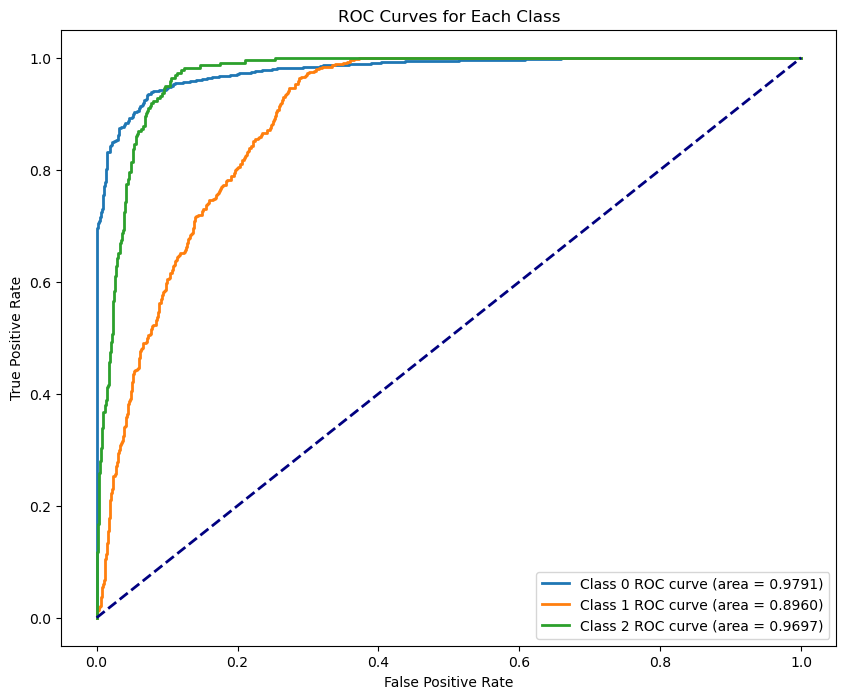

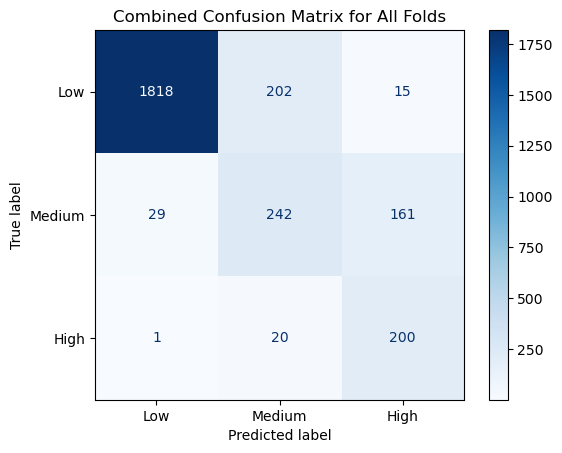

              precision    recall  f1-score   support

         Low       0.98      0.89      0.94      2035
      Medium       0.52      0.56      0.54       432
        High       0.53      0.90      0.67       221

    accuracy                           0.84      2688
   macro avg       0.68      0.79      0.72      2688
weighted avg       0.87      0.84      0.85      2688



In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

def focal_loss(alpha, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        # Convert labels to one-hot encoding
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)  # Prevent division by zero

        # Compute cross-entropy loss
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Compute focal loss component
        weights = tf.pow(1 - y_pred, gamma)
        fl = alpha * weights * cross_entropy

        # Sum the losses in mini-batch
        return tf.reduce_mean(tf.reduce_sum(fl, axis=1))
    return focal_loss_fixed

def create_model(temporal_input_shape, spatial_input_shape, lstm_units=128, gru_units=64, 
                 dropout_rate=0.3, learning_rate=0.001, alpha=None, gamma=2.0):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=True)(x)  # Added another GRU layer
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units // 2, activation='relu')(x)  # Reduce units for the next GRU layer
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(32, activation='relu')(combined)  # Increase the dense layer units
    combined = Dropout(dropout_rate)(combined)
    output = Dense(3, activation='softmax', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss=focal_loss(alpha=alpha, gamma=gamma), 
                  metrics=['accuracy'])
    
    return model

# Setting up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
f1_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0003

# Class weights and focal loss parameters
class_weights = {0: 1.0, 1: 5.0, 2: 12.0}
alpha = np.array([class_weights[0], class_weights[1], class_weights[2]])
gamma = 2  # Adjust as needed

# Iterate through each fold
for train_index, val_index in skf.split(X_temporal, y):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]),
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        alpha=alpha,
        gamma=gamma
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, len(spatial_features))],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, len(spatial_features))], y_val),
        epochs=100,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, len(spatial_features))])

    # Collect predictions and true values for metrics
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # Calculate and store metrics
    fold_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='weighted')
    accuracy = accuracy_score(y_val, y_pred_classes)
    f1 = f1_score(y_val, y_pred_classes, average='macro')
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f"Fold AUC (OvR): {fold_auc:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Display mean and standard deviation of metrics
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Calculate AUC for each class individually
auc_per_class = roc_auc_score(all_y_val, all_y_pred_prob, multi_class='ovr', average=None)
for i, auc_score in enumerate(auc_per_class):
    print(f"AUC for class {i}: {auc_score:.4f}")

# Mean AUC across classes
mean_auc_per_class = np.mean(auc_per_class)
print(f"Mean AUC across classes: {mean_auc_per_class:.4f}")

# Create the comprehensive ROC curve for all classes
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(np.array(all_y_val) == i, np.array(all_y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = np.argmax(np.array(all_y_pred_prob), axis=1)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()

print(classification_report(all_y_val, all_y_pred_classes, target_names=["Low", "Medium", "High"]))

In [41]:
model.save('crime_prediction_model.h5')

In [56]:
from tensorflow.keras.models import load_model

# Define the number of timesteps used in the model
timesteps = 17  # Adjust based on model configuration

# Extract temporal features for the last sequence (N=timesteps) across all blocks
X_temporal_new = crime_time_series[temporal_features].iloc[-timesteps:].values
X_temporal_new = X_temporal_new.reshape((1, timesteps, len(temporal_features)))  # Shape: (1, timesteps, num_temporal_features)

# Extract the latest spatial feature value (census block ID) for all blocks
X_spatial_new = crime_time_series[spatial_features].iloc[-1:].values  # Latest data for spatial feature
X_spatial_new = X_spatial_new.reshape((1, 1, 1, len(spatial_features)))  # Shape: (1, 1, 1, num_spatial_features)

# Make predictions for all census blocks
y_pred_prob_future = loaded_model.predict([X_temporal_new, X_spatial_new])

# Get the predicted classes and probabilities for each census block
y_pred_classes_future = np.argmax(y_pred_prob_future, axis=1)

# Display predictions for each census block
print("Predicted Classes and Probabilities for Each Census Block (One Week Out):")
for i, (pred_class, prob) in enumerate(zip(y_pred_classes_future, y_pred_prob_future)):
    print(f"Census Block {i}: Predicted Class = {pred_class}, Probabilities = {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
Predicted Classes and Probabilities for Each Census Block (One Week Out):
Census Block 0: Predicted Class = 0, Probabilities = [1. 0. 0.]


In [69]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).agg({
    'dow': 'first',  
    'hour_of_day': 'first',
    'extracted_month': 'first',
    'extracted_day': 'first',
    'temp_max': 'first',
    'temp_min': 'first',
    'daylight_duration': 'first',
    'precipitation_sum': 'first',
    'precipitation_hours': 'first',
    'time_block_numeric': 'first'
}).reset_index()

crime_time_series['Crime_Count_D'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).size().values

# Step 1: Compute the median of weekly crime counts
median_count = crime_time_series['Crime_Count_D'].median()

# Step 2: Create buckets based on the median
crime_time_series['Crime_Count_Bucket'] = np.where(
    crime_time_series['Crime_Count_D'] >= median_count, 1, 0
)

crime_time_series = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

# Display the updated dataframe
crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_D,Crime_Count_Bucket
0,0,2,17,1,1,11.570000,0.139999,33280.367188,0.051181,12.0,0,19,1
42711,71,2,0,1,1,11.827398,0.397396,33280.367188,0.051181,12.0,3,17,1
40901,70,2,0,1,1,12.878599,2.258602,33253.820312,0.082677,18.0,3,9,1
90102,138,2,9,1,1,14.008101,4.918100,33253.820312,0.082677,20.0,2,3,1
70201,94,2,15,1,1,11.897600,0.467596,33280.367188,0.051181,12.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19134,10,7,20,1,1,45.700000,35.100000,33211.740000,0.035000,7.0,1,1,0
59190,80,7,19,1,1,49.820000,35.689999,33264.988281,0.007874,2.0,1,2,1
101804,190,7,21,1,1,50.147598,36.017601,33264.988281,0.007874,2.0,1,2,1
44512,71,7,21,1,1,49.139603,34.109600,33264.988281,0.011811,3.0,1,1,0


In [71]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_Count_Bucket'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_Count_Bucket')['Crime_Count_D'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_Count_Bucket
1    73663
0    41205
Name: count, dtype: int64
Bucket Summary Statistics:
                       count     mean       std  min  25%  50%  75%   max
Crime_Count_Bucket                                                      
0                   41205.0  1.00000  0.000000  1.0  1.0  1.0  1.0   1.0
1                   73663.0  4.32832  2.741352  2.0  2.0  3.0  6.0  33.0


In [74]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours', 'time_block_numeric']

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_Count_Bucket'].values  # Use binary bucket target
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 7

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (16409, 7, 10)
X_spatial: (16409, 1)
y: (16409,)


Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6327 - loss: 0.6644 - val_accuracy: 0.6380 - val_loss: 0.6387
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6437 - loss: 0.6365 - val_accuracy: 0.6627 - val_loss: 0.6283
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6621 - loss: 0.6314 - val_accuracy: 0.6630 - val_loss: 0.6254
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6690 - loss: 0.6276 - val_accuracy: 0.6676 - val_loss: 0.6253
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6631 - loss: 0.6283 - val_accuracy: 0.6709 - val_loss: 0.6260
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6714 - loss: 0.6255 - val_accuracy: 0.6712 - val_loss: 0.6257
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6670 - loss: 0.6314 - val_accuracy: 0.6670 - val_loss: 0.6244
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6709 - loss: 0.6278 - 

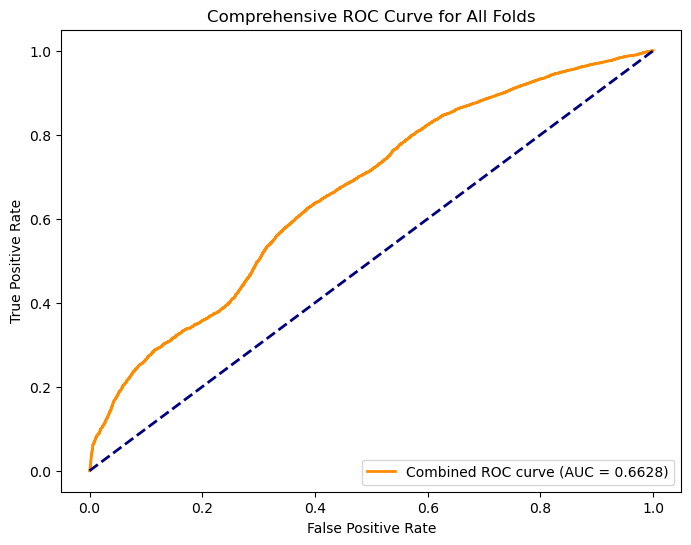

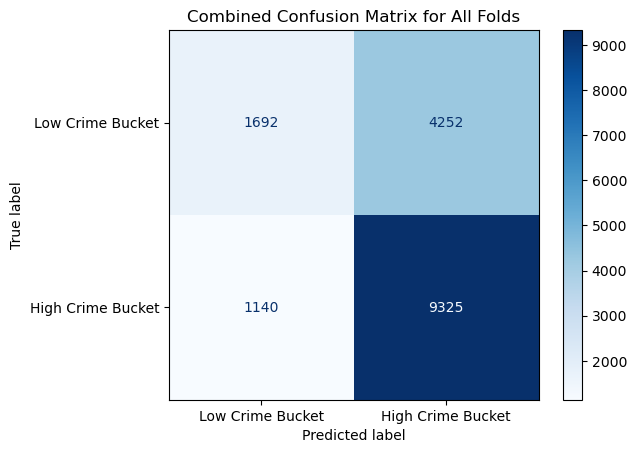

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define the model in a function to allow re-instantiation
def create_model(temporal_input_shape, spatial_input_shape, lstm_units=64, gru_units=32, dropout_rate=0.3, learning_rate=0.001):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(16, activation='relu')(combined)
    output = Dense(1, activation='sigmoid', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters to try
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0005

# Iterate through each fold
for train_index, val_index in kf.split(X_temporal):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]), 
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, 1)],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)], y_val),
        epochs=100,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)]).flatten()
    y_pred_classes = (y_pred_prob > 0.5).astype(int)

    # Collect predictions and true values for the combined AUC and confusion matrix
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)

    # Rename `auc` variable to avoid conflict with `auc` function
    fold_auc = roc_auc_score(y_val, y_pred_prob)
    accuracy = accuracy_score(y_val, y_pred_classes)
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)

    print(f"Fold AUC: {fold_auc:.4f}, Accuracy: {accuracy:.4f}")

# Display mean and standard deviation of AUC and accuracy across all folds
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")

# Create the comprehensive ROC curve for all folds combined
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_prob)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Combined ROC curve (AUC = {combined_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comprehensive ROC Curve for All Folds')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = (np.array(all_y_pred_prob) > 0.5).astype(int)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Crime Bucket", "High Crime Bucket"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()